In [1]:
import sys,os
import numpy as np
import cupy as cp

from quspin.basis import spin_basis_1d, spin_basis_general
from quspin.operators import hamiltonian,quantum_operator

os.environ['KMP_DUPLICATE_LIB_OK']='True' # uncomment this line if omp error occurs on OSX for python 3
os.environ['OMP_NUM_THREADS']='1' # set number of OpenMP threads to run in parallel
os.environ['MKL_NUM_THREADS']='12' # set number of MKL threads to run in parallel

In [2]:
Sz = np.zeros([2,2])
Sz[0,0] = 1/2
Sz[1,1] = -1/2
Sx = np.zeros([2,2])
Sx[1,0] = 1/2
Sx[0,1] = 1/2
Sy = np.zeros([2,2], dtype=np.complex64)
Sy[1,0] = 1j/2
Sy[0,1] = -1j/2

I = np.eye(2)
I4 = np.eye(4)

In [3]:
SzSz = np.kron(Sz,Sz).real.astype(np.float64)
SxSx = np.kron(Sx,Sx).real.astype(np.float64)
SySy = np.kron(Sy,Sy).real.astype(np.float64)
o = np.kron(I, Sz) + np.kron(Sz, I)
Sp = (Sx + 1j*Sy).real
Sm = (Sx - 1j*Sy).real
G_ = np.kron(Sp, Sm) + np.kron(Sm, Sp)

In [54]:
L = 10
x = np.load("1D_symm.npy")
sys.path.append('../reduce_nsp')

In [56]:

from nsp.utils import l2nl

G2 = np.zeros((2**L, 2**L))
for bond in [[i, j] for i in range(L) for j in range(L) if i < j]:
    G2 += l2nl(G_.reshape(4,4), L, bond , sps=2)
    
G2_gpu = cp.asarray(G2)

G3 = np.zeros((2**L, 2**L))
for bond in [[i, j] for i in range(L) for j in range(L) if i < j]:
    G3 += l2nl(x.reshape(4,4), L, bond , sps=2)
    
G3_gpu = cp.asarray(G3)

In [57]:
y = x.reshape(2,2,2,2).copy()
for i in range(2):
    y[:,i,:,i] = 0
    y[i,:,i,:] = 0    
G4 = np.zeros((2**L, 2**L))
for bond in [[i, j] for i in range(L) for j in range(L) if i < j]:
    G4 += l2nl(y.reshape(4,4).T, L, bond , sps=2)
    
G4_gpu = cp.asarray(G4)
np.save("1D_no_onesite.npy", y)


In [58]:
z = x.reshape(2,2,2,2).copy()
for i in range(2):
    for j in range(2):
        z[j,i,j,i] = 0
        z[i,j,i,j] = 0    
G5 = np.zeros((2**L, 2**L))
for bond in [[i, j] for i in range(L) for j in range(L) if i < j]:
    G5 += l2nl(z.reshape(4,4), L, bond , sps=2)
    
G5_gpu = cp.asarray(G5)
np.save("1D_no_diagonal.npy", z)

In [59]:
# o1 = y.reshape(4,4).copy()
# o1[0,3] = o1[3,0] = 0

# np.save("test.npy", o1)

In [60]:
a1 = np.zeros((4,4))
a1[1,2] = a1[2,1] = 1
a2 = np.zeros((4,4))
a2[3,0] = a2[0,3] = 1
a3 = np.zeros((4,4))
a3[3,0] = a3[0,3] = 1

In [61]:
E1 = l2nl(a1, L, [0,1] , sps=2)
# for bond in [[i, j] for i in range(L) for j in range(L) if i < j]:
#     G6 += l2nl(np.ones(16).reshape(4,4), L, bond , sps=2)
E1 = cp.asarray(E1)


E2 = l2nl(a2, L, [0,1] , sps=2)
E2 = cp.asarray(E2)
E3 = l2nl(a3, L, [0,1] , sps=2)
E3 = cp.asarray(E3)


In [85]:
Jz, Jx, Jy, hz, hx = [-1, -0.5, -0.3, 0, 0.5]
# Jz, Jx, Jy, hz, hx = [0,0,0, 0, 1]


J_zz = [[1,i,(i+1)%L] for i in range(L)]
J_xy = [[1,i,(i+1)%L] for i in range(L)]
h_list = [[-1.0,i] for i in range(L)]
ops_dict = dict(Jz=[["zz", J_zz]], # J for z
                Jx=[["xx",J_xy]], # J for x and y
                Jy=[["yy",J_xy]],
                hz=[["z",h_list]],
                hx=[["x",h_list]])
Mz_list = [[1.0/L,i] for i in range(L)]
# Mx_list = [[0.3/L,i] for i in range(L)]
G_list = [[1.0, i, j] for i in range(L) for j in range(L) if i < j]

basis_2d = spin_basis_1d(L ,pauli=False)
_H = quantum_operator(ops_dict,basis=basis_2d, dtype=np.float64, check_symm=False)
M = hamiltonian([["z",Mz_list]],[],basis=basis_2d, dtype=np.float64)
G = hamiltonian([["-+",G_list], ["+-",G_list]],[],basis=basis_2d, dtype=np.float64)
params_dict=dict(Jz=Jz, Jx=Jx,Jy=Jy,hz=hz, hx=hx)

Hermiticity check passed!
Hermiticity check passed!
Hermiticity check passed!


/tmp/ipykernel_3597/1330534070.py:19: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  M = hamiltonian([["z",Mz_list]],[],basis=basis_2d, dtype=np.float64)
/tmp/ipykernel_3597/1330534070.py:20: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  G = hamiltonian([["-+",G_list], ["+-",G_list]],[],basis=basis_2d, dtype=np.float64)


In [86]:
Hs = _H.tohamiltonian(params_dict)
H = Hs.toarray()
H_gpu = cp.asarray(H)

M_np = M.toarray()
M_gpu = cp.asarray(M_np)
G_gpu = cp.asarray(G.toarray())

In [87]:
E, V = cp.linalg.eigh(H_gpu)

In [88]:
T = 0.5
beta = 1/T
Z = cp.exp(-beta*E).sum()
M_mean = cp.einsum("n,in,jn,ij->", cp.exp(-beta*E), V, V, M_gpu) / Z
M2_mean = cp.einsum("n,in,jn,ij->", cp.exp(-beta*E), V, V, M_gpu@M_gpu) / Z
E_mean = (E*cp.exp(-beta*E)).sum() / Z
E_square_mean = ((E*E)*cp.exp(-beta*E)).sum() / Z
G_mean = cp.einsum("n,in,jn,ij->", cp.exp(-beta*E), V, V, G_gpu) / Z
G2_mean = cp.einsum("n,in,jn,ij->", cp.exp(-beta*E), V, V, G2_gpu) / Z
G3_mean = cp.einsum("n,in,jn,ij->", cp.exp(-beta*E), V, V, G3_gpu) / Z
G4_mean = cp.einsum("n,in,jn,ij->", cp.exp(-beta*E), V, V, G4_gpu) / Z
G5_mean = cp.einsum("n,in,jn,ij->", cp.exp(-beta*E), V, V, G5_gpu) / Z
E1_mean = cp.einsum("n,in,jn,ij->", cp.exp(-beta*E), V, V, E1) / Z
E2_mean = cp.einsum("n,in,jn,ij->", cp.exp(-beta*E), V, V, E2) / Z

In [89]:
print(f"L = {L}", params_dict)
print(f"T               = {T}")
print(f"E               = {E_mean / L}")
print(f"C               = {(E_square_mean - E_mean**2)*(beta**2)/L}")
print(f"M               = {M_mean}")
print(f"M^2             = {M2_mean}")
print(f"G               = {G_mean}")
print(f"G2(G)           = {G2_mean}")
print(f"G3              = {G3_mean}")
print(f"G4(No one site) = {G4_mean}")
print(f"G5(No diagonal) = {G5_mean}")
# print(f"phys cnt        = {1 / G6_mean}")
print(f"E1        = {E1_mean}")
print(f"E2        = {E2_mean}")

L = 10 {'Jz': -1, 'Jx': -0.5, 'Jy': -0.3, 'hz': 0, 'hx': 0.5}
T               = 0.5
E               = -0.2736138128788793
C               = 0.3662476778743276
M               = 6.24182507588853e-17
M^2             = 0.05306183609143414
G               = 7.666517421510369
G2(G)           = 7.666517421510369
G3              = 49.60855539250431
G4(No one site) = 4.1621521823148235
G5(No diagonal) = 39.59685908272231
E1        = 0.198012706392768
E2        = 0.20699433965346836


In [630]:
0.020723304513837117 / 0.605358

0.03423313892578791

In [618]:
8.464660399793908 / 3.72963

2.2695710834034233

In [619]:
0.17719472483205861 / 0.171871

1.030975119898404

In [620]:
0.2728582784660241 / 0.250143

1.090809171018274

In [621]:
0.3872213252980646 / 0.330939

1.1700685784935128

In [449]:
0.5208056763100141 / 0.412862

1.2614521954309528

In [461]:
0.6738376801266748 / 0.48966

1.3761338073901785

In [473]:
0.846417397441997 / 0.569147

1.487168336900655

In [485]:
1.0385878074655466 / 0.643328

1.6143985765667692

In [497]:
1.2503667614679046 / 0.721431

1.7331758151062326

In [509]:
1.4817614530671108 / 0.789988 

1.875675900225207

In [520]:
y = [1.030975119898404, 
 1.090809171018274,
 1.1700685784935128,
 1.2614521954309528,
 1.3761338073901785,
 1.487168336900655,
 1.6143985765667692,
 1.7331758151062326,
 1.875675900225207
]
y = np.array(y)
x = np.arange(4, 13)

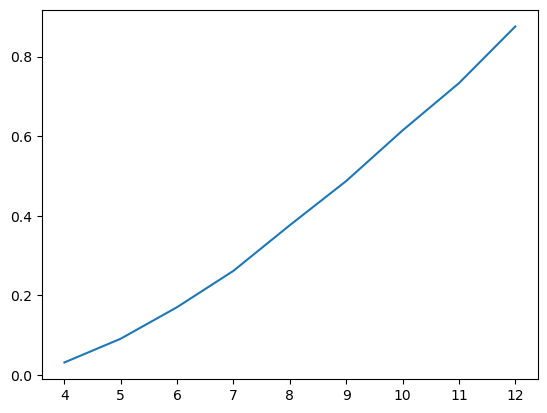

In [524]:
from matplotlib import pyplot as plt

# plt.yscale('log')
# plt.xscale('log')
plt.plot(x, y - 1)
